# Non Leased Housing Survey Data Analysis.  
 
* Ashwin Nair

**Data:** We are looking at survey data, student details with their most recent coop. 
* Time of Coop : Spring, Summer I, Summer II, and Fall
* Time of Securing Housing: T - <Time in days/weeks/months>
* Finalized Housing through : Coop employer, Beyond Boston, FB groups, rental sites etc.
* Type of Housing & Amenities available: Corporate/Privat/University 
* Rent + Utilites
* Recommendation Likelihood: Scored from 0 - 5 from very unlikely to very likely.
* Commute Options: Car needed, walking, public transport, Rideshare etc.
* Advice to Students


# Goal

* **Clean the dataset to include only those rows that have at least information about a certain category**
* **Build a clustering model beteween major features namely Rent, Amenities, Roomates, City, Commute**
* **Understand the attributes students are most inclined to and how we can help navigate the apartment search process**

In [1]:
import pandas as pd

from pandas import ExcelWriter
from pandas import ExcelFile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

%matplotlib inline


from datetime import datetime

import io, os, sys, types


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

In [2]:

def excelread(xlFile):
    data = pd.read_excel(xlFile)
    print(data)
    return data

### I have taken the best optimized sample that will give us results that apply to 60% of the dataset. (NY, LA, SF, San Jose, Chicago, Washington)

In [3]:
excelData = excelread('NonLeasedSurveyF.xlsx')

     Most_Recent_Coop  City_Rank Spring Summer_1 Summer_2 Fall  \
0        San Jose, CA          4    NaN      Yes      Yes  Yes   
1        New York, NY          1    NaN      NaN      Yes  Yes   
2         Chicago, IL          5    NaN      Yes      Yes  Yes   
3        New York, NY          1    NaN      NaN      Yes  Yes   
4        New York, NY          1    NaN      NaN      Yes  Yes   
5   San Francisco, CA          2    NaN      Yes      Yes  Yes   
6        New York, NY          1    NaN      NaN      NaN  Yes   
7        New York, NY          1    NaN      NaN      Yes  Yes   
8        New York, NY          1    NaN      NaN      Yes  Yes   
9        New York, NY          1    NaN      NaN      Yes  Yes   
10        Chicago, IL          5    NaN      NaN      Yes  Yes   
11    Los Angeles, CA          3    NaN      Yes      Yes  NaN   
12       New York, NY          1    NaN      Yes      Yes  Yes   
13       New York, NY          1    NaN      NaN      Yes  Yes   
14       N

In [4]:
excelData.columns

Index(['Most_Recent_Coop', 'City_Rank', 'Spring', 'Summer_1', 'Summer_2',
       'Fall', 'Timeline_Housing_Secure', 'Housing_Coop', 'Housing_BB',
       'Housing _FB', 'Housing_Apartments.com', 'Housing_Airbnb',
       'Housing _Local', 'Housing_Realtor', 'Housing_Type', 'Terms_of_Stay',
       'Rent_Utilities', 'Furnished', 'Parking', 'Pets_allowed',
       'Laundry_access', 'Air_Conditioning', 'ADA_Accessible', 'Dishwasher',
       'Patio_Balcony_Porch_Deck', 'Smoke_free', 'Fitness_room', 'Pool',
       'Utilities_included', 'WiFi', 'Security_guard', 'Video_surveillance',
       'Security_system', 'Amenity_Rank', 'Water', 'Gas', 'Electricity',
       'Internet', 'Cable', 'Basic_Rank', 'Roomates',
       'Recommendation_Likelihood ', 'Address', 'Car_Needed', 'Commute',
       'Advice', 'Student_Details'],
      dtype='object')

# Descriptive Statistics

In [5]:
excelData['Most_Recent_Coop'].describe()

count               55
unique               6
top       New York, NY
freq                26
Name: Most_Recent_Coop, dtype: object

## The most frequent Coop destination - New York (26 rows)

In [6]:
excelData['Timeline_Housing_Secure'].describe()

count       55
unique       3
top       T-4W
freq        25
Name: Timeline_Housing_Secure, dtype: object

## Students confirm the housing T-4 weeks mostly.

In [7]:
excelData['Housing_Type'].describe()

count                                 55
unique                                 5
top       Privately owned apartment/flat
freq                                  41
Name: Housing_Type, dtype: object

## The most common housing type -Private Owned Apartment (41 rows)

In [8]:
excelData['Rent_Utilities'] = excelData['Rent_Utilities'].str.replace('$', '')
excelData['Rent_Utilities'] = excelData['Rent_Utilities'].str.replace(',', '')


In [9]:
excelData['Rent_Utilities'] = pd.to_numeric(excelData['Rent_Utilities'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001850167A208>]],
      dtype=object)

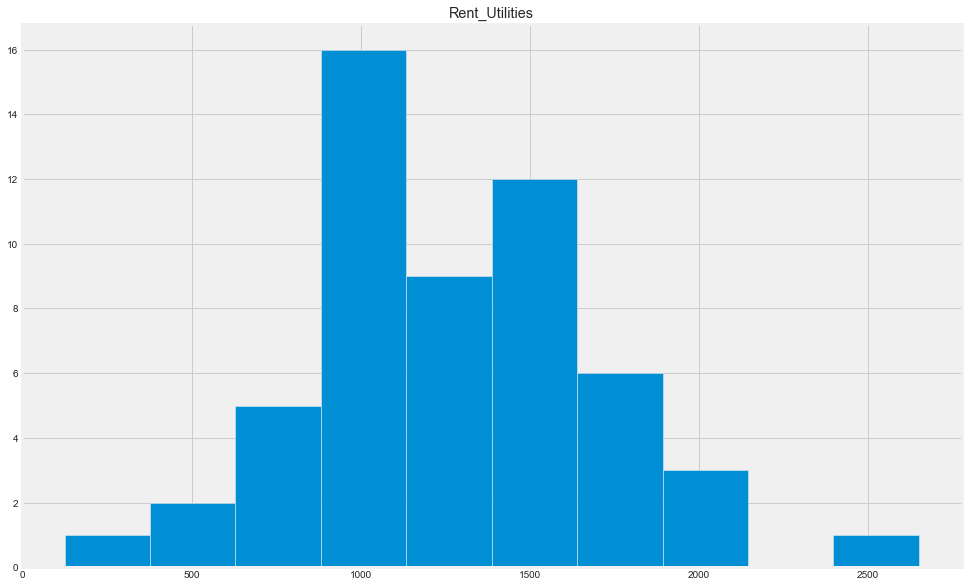

In [10]:
excelData.hist(column='Rent_Utilities', figsize=(15,10))

## We see that the average price per month varies around 1000USD for maximum apartments

## Clustering Algorithm for most liked apartments / housing based on Amenities & Basic utilities

Selecting features that are we can model to show correlation to the likelihood of student living in the apartment

In [11]:
excelData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
City_Rank,55.0,2.218182,1.583373,1.0,1.0,2.0,3.0,6.0
Rent_Utilities,55.0,1271.363636,436.989336,125.0,1000.0,1200.0,1550.0,2650.0
Amenity_Rank,55.0,6.563636,2.820321,1.0,5.0,6.0,8.0,15.0
Basic_Rank,55.0,2.236364,1.943304,0.0,0.0,2.0,4.0,5.0
Roomates,55.0,2.327273,1.217991,0.0,1.0,2.0,3.0,4.0
Car_Needed,55.0,0.181818,0.389249,0.0,0.0,0.0,0.0,1.0


In [12]:
features = ['City_Rank','Rent_Utilities','Amenity_Rank', 'Basic_Rank',
        'Roomates','Car_Needed']

In [13]:
select_df = excelData[features]
select_df

,City_Rank,Rent_Utilities,Amenity_Rank,Basic_Rank,Roomates,Car_Needed
0,4,750,6,2,3,1
1,1,1700,5,0,3,0
2,5,600,7,0,3,0
3,1,1600,5,1,2,0
4,1,1100,5,5,4,0
5,2,1270,15,2,3,0
6,1,1375,5,4,4,0
7,1,2000,5,0,1,0
8,1,1400,8,1,1,0
9,1,125,2,0,4,1


In [14]:
X = StandardScaler().fit_transform(select_df)
X

array([[ 1.13570244e+00, -1.20407728e+00, -2.01690284e-01,
        -1.22750806e-01,  5.57416061e-01,  2.12132034e+00],
       [-7.76449629e-01,  9.89925787e-01, -5.59527884e-01,
        -1.16141147e+00,  5.57416061e-01, -4.71404521e-01],
       [ 1.77308647e+00, -1.55049882e+00,  1.56147316e-01,
        -1.16141147e+00,  5.57416061e-01, -4.71404521e-01],
       [-7.76449629e-01,  7.58978095e-01, -5.59527884e-01,
        -6.42081138e-01, -2.71175381e-01, -4.71404521e-01],
       [-7.76449629e-01, -3.95760362e-01, -5.59527884e-01,
         1.43524019e+00,  1.38600750e+00, -4.71404521e-01],
       [-1.39065605e-01, -3.14928670e-03,  3.01884812e+00,
        -1.22750806e-01,  5.57416061e-01, -4.71404521e-01],
       [-7.76449629e-01,  2.39345789e-01, -5.59527884e-01,
         9.15909859e-01,  1.38600750e+00, -4.71404521e-01],
       [-7.76449629e-01,  1.68276886e+00, -5.59527884e-01,
        -1.16141147e+00, -1.09976682e+00, -4.71404521e-01],
       [-7.76449629e-01,  2.97082712e-01,  5.139

Using K means clustering

In [15]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


**Centers of the 12 Clusters formed:**

In [16]:
centers = model.cluster_centers_
centers

array([[-0.45775762, -0.75372928,  1.22966012, -0.51224856,  0.55741606,
        -0.47140452],
       [-0.13906561,  0.14696671,  0.33506612,  1.08901997, -0.82356968,
        -0.47140452],
       [ 0.97635644,  0.16717464,  0.33506612,  1.17557503, -0.06402752,
         2.12132034],
       [-0.35152695,  2.20240117,  0.39470572, -1.16141147, -1.37596397,
        -0.47140452],
       [-0.61710362, -0.73063452, -1.27520308, -0.9017463 ,  0.14312034,
        -0.47140452],
       [-0.58523442, -0.28606021, -0.34482532,  1.12364199,  0.88885264,
        -0.47140452],
       [ 1.98554781, -0.54972549,  1.22966012, -1.16141147, -0.27117538,
        -0.47140452],
       [-0.71271123,  0.81671502, -0.34482532, -0.48628204, -0.35403452,
        -0.47140452],
       [-0.13906561,  0.44142502, -0.91736548, -0.64208114, -1.92835826,
         2.12132034],
       [ 0.33897241, -1.10303767, -0.55952788, -0.9017463 ,  1.17885964,
         2.12132034],
       [ 1.77308647, -0.61516067, -0.73844668, -1.

Plotting graphs for better representation

In [17]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [18]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [19]:
P = pd_centers(features, centers)
P

,City_Rank,Rent_Utilities,Amenity_Rank,Basic_Rank,Roomates,Car_Needed,prediction
0,-0.457758,-0.753729,1.229660,-0.512249,0.557416,-0.471405,0
1,-0.139066,0.146967,0.335066,1.089020,-0.823570,-0.471405,1
2,0.976356,0.167175,0.335066,1.175575,-0.064028,2.121320,2
3,-0.351527,2.202401,0.394706,-1.161411,-1.375964,-0.471405,3
4,-0.617104,-0.730635,-1.275203,-0.901746,0.143120,-0.471405,4
5,-0.585234,-0.286060,-0.344825,1.123642,0.888853,-0.471405,5
6,1.985548,-0.549725,1.229660,-1.161411,-0.271175,-0.471405,6
7,-0.712711,0.816715,-0.344825,-0.486282,-0.354035,-0.471405,7
8,-0.139066,0.441425,-0.917365,-0.642081,-1.928358,2.121320,8
9,0.338972,-1.103038,-0.559528,-0.901746,1.178860,2.121320,9


### Basic Rank 

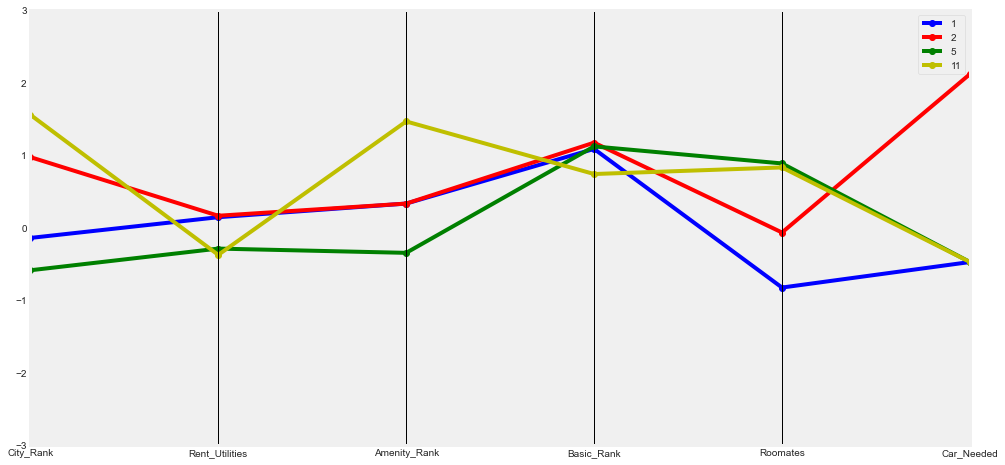

In [20]:
parallel_plot(P[P['Basic_Rank'] > 0.5])

### Amenity Rank 

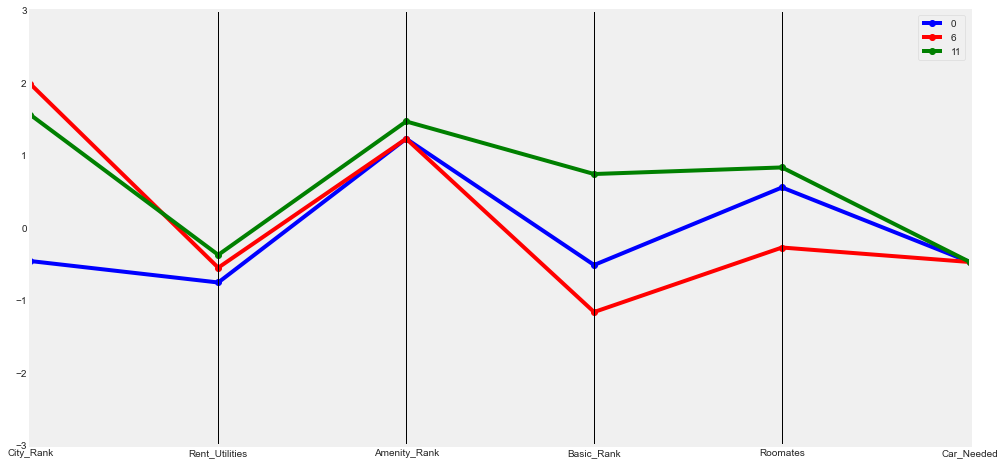

In [21]:
parallel_plot(P[P['Amenity_Rank'] > 0.75])

### Reasonable Rent & Good Amenities

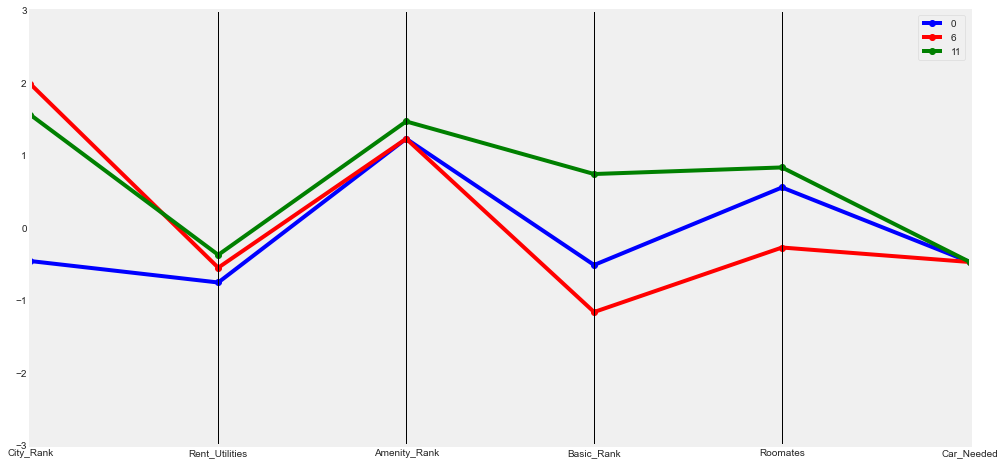

In [22]:
parallel_plot(P[(P['Amenity_Rank'] > 0.5) & (P['Rent_Utilities'] < 0.5)])

Basic & Amenity Rank:
Every line can be classified as a cluster 
The city they are in is a distinguishing factor
Having all amenities changes students behavior with city. However, sharing with more students shows slight concern. Needing a car is a very distinguishing cluster.
When the rent is less and amenities are more than average, the basic utilites seems to show a change in behaviour.


### Car Needed

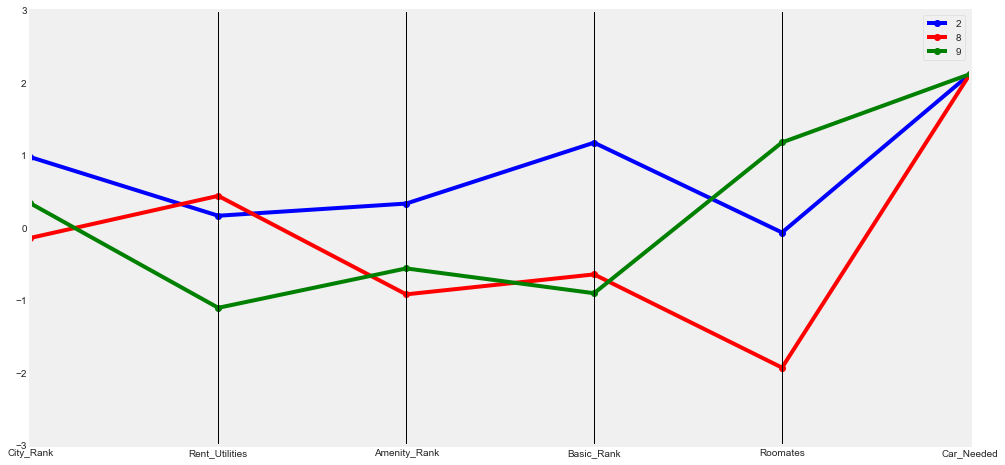

In [23]:
parallel_plot(P[P['Car_Needed'] > 0])

Having roomates becomes less of a problem when there is a car needed.Rent & Amenities tend to the be two aspects most focussed on.

In [24]:
import collections

file=open('Advice.txt', encoding="utf8")

In [25]:
stopwords = set(line.strip() for line in open('stopwords'))

In [26]:
wordcount={}

In [27]:
for word in file.read().lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace("\"","")
    word = word.replace("“","")
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

In [28]:
d = collections.Counter(wordcount)

In [29]:
print(d.most_common(10))
for word, count in d.most_common(10):
	print(word, ": ", count)


[('housing', 15), ('live', 9), ('find', 8), ('try', 8), ('apartment', 7), ('living', 6), ('car', 6), ('expensive', 5), ('new', 5), ('close', 5)]
housing :  15
live :  9
find :  8
try :  8
apartment :  7
living :  6
car :  6
expensive :  5
new :  5
close :  5
